## Урок 4. Деревья решений

# 1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  

### Добавил два критерия останова:
    1) глубина дерева
    2) кол-во объектов в листе

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [47]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5
                                                                         )

In [48]:
classification_data # данные сгенерированные по x и y(по умолчанию 100 объектов) на 2 меры 

array([[-0.48221702, -0.28206699],
       [ 1.41747159, -0.86709816],
       [ 0.88378869, -0.92475428],
       [ 0.7469239 , -1.2160026 ],
       [-0.11161925,  0.07390672],
       [-0.58749226, -0.66081696],
       [-0.88183821, -0.55448172],
       [-2.10674166, -1.99108522],
       [-0.566895  , -1.06057167],
       [ 2.12945908, -0.34878879],
       [ 1.24936047, -0.71891837],
       [ 2.15694675, -0.99280756],
       [-0.4747746 ,  0.44731927],
       [ 0.23456461, -1.92487075],
       [-1.79019556, -1.41552354],
       [-0.50977934, -0.11662801],
       [ 2.62728189,  0.05877427],
       [-0.18074965,  0.12120859],
       [-1.41216434, -2.89426972],
       [ 0.512618  , -0.60786361],
       [ 0.08490007, -1.52259229],
       [-0.08810642, -1.52088966],
       [ 0.59148992, -0.87677056],
       [ 0.3960253 , -1.67064887],
       [-0.67449854, -0.52577294],
       [ 2.00141541, -0.03761801],
       [ 1.84208015, -0.34586556],
       [-0.62365955, -0.92164859],
       [ 0.97916906,

In [49]:
classification_labels #+ метки принадлежности к классу

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1])

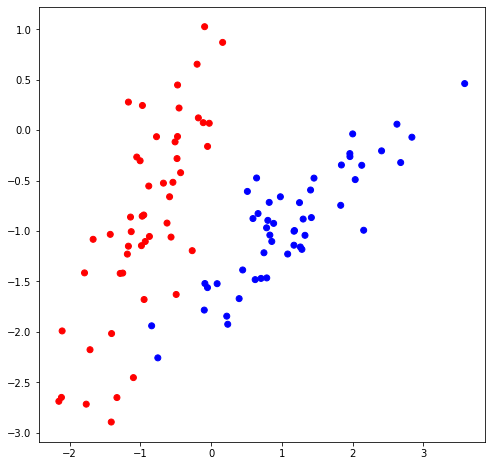

In [50]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [51]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, depth_max):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.depth_max =  depth_max


In [52]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels,  depth_max):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.depth_max =  depth_max
      
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [53]:
# Расчет критерия Джини

def gini(labels): # 70 объектов тренировочной выборки
    #  подсчет количества объектов разных классов
    classes = {} # добавляет в словарь кол-во объектов класса 1 и кол-во объектов класса 0
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини (установлен по дефолту)
    for label in classes:
        p = classes[label] / len(labels) # кол-во объектов одного класса / кол-во всех объектов двух классов (35/70 =0,5)
        impurity -= p ** 2 # вероятность возводится в квадрат и вычитается из коэф неопр. Джинни (1-0,5*0,5=0,75)
        # затем кол-во объектов противоположного класса / кол-во всех объектов (35/70=0,5), 
        #возводится в квадрат и вычитается из предыдущего значения impurity 0,75 -0,5**2  = 0,5
        
        
    return impurity #критерий Джинни = 0,5

In [54]:
# Расчет качества

def quality(left_labels, right_labels, current_gini): #5 left[0,0,0,0,0] , 
    #65 right[0,1,1,1,0,1,0,1,1,1,0,0,1...] gini = 0.5

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # p=  5 / (5+65) =0,0714285714285714
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # 0.5 - 0,07142857* .. пересчитываем коэф. Джинни и возвращаем для сравнения

In [55]:
# Разбиение датасета в узле

def split(data, labels, index, t): # передача признаков x, значений (принадлежности к классу) y,
    #индекс признака (1 или 2), уникальное значение объекта в массиве объектов признака
    
    left = np.where(data[:, index] <= t)#берет в первой итерации по признаку 1 все значения и ищет 
    #номер индекса, где значение превышает t (например 2.1016 в позиции 44). или несколько индексов превышения (44,49)
    #Таким образом в левую выборку попадает 44 значения по критерию t<=2.1016
    right = np.where(data[:, index] > t) # на противоположный край попадет 26 значений
        
    true_data = data[left] # правильные значения [[-2.1016,-1.9910]] по 44 позиции
    false_data = data[right] # ложные значения все что ниже 44 позиции
    true_labels = labels[left] # на примере 1 итерации относится к классу 0
    false_labels = labels[right] # остальные массив значений 1 и 0
        
    return true_data, false_data, true_labels, false_labels

### Добавлен критрерий на кол-во объектов листа

In [56]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf2): # 70% значений X и 70% значений y
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = min_leaf2

    current_gini = gini(labels) # переход в функцию расчета коэф. Джинни (возврат 0,5)

    best_quality = 0 # дефолтно  = 0
    best_t = None #  значение не задано
    best_index = None # значение не задано
    
    n_features = data.shape[1] # кол-во признаков, в примере = 2
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data]) # уникальные пороговые значения t, признака 0 и 1
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)# переход в функцию разделения
            #true_data правильные значения [[-2.1016,-1.9910]] по 44 позиции / или если 44,49 [[-2.1016,-1.9910],[-1.79,1.41]]
            # false_data ложные значения все что ниже и выше 44 позиции, массив значений  / или ложные значения все что ниже и выше 44,49
            #true_labels на примере 1 итерации относится к классу 0 / или если 44,49 : 0,0
            # false_labels остальные массив значений 1 и 0
            
            
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf: # 1 < 5 или 69 < 5 / или если 44,49: 2 < 5 или 68 < 5
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini) # если больше 5 попало при определенном разделении,то
            # переходим в функцию расчета качества и получаем новый коэфф Джинни с учетом текщего разделения
            
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

### Добавлен критерий останова на глубину дерева и кол-во объектов на листе

In [113]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf2, depth_max, depth_incr = 0):

    quality, t, index = find_best_split(data, labels,min_leaf2)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth_incr >=depth_max:
        if depth_incr>=depth_max:
            print(f"Дерево с глубиной {depth_incr} построено")
        return Leaf(data, labels,depth_max )

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева

    depth_incr = depth_incr + 1
    print("уровень дерева = ", depth_incr)
    true_branch = build_tree(true_data, true_labels,min_leaf2,depth_max,depth_incr)
    false_branch = build_tree(false_data, false_labels,min_leaf2,depth_max,depth_incr)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch,depth_max)

In [114]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [115]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [116]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection
# сгенерированную выборку разобьем на тренировочную и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [139]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels,min_leaf2=2,depth_max=2)

уровень дерева =  1
уровень дерева =  2
Дерево с глубиной 2 построено
Дерево с глубиной 2 построено


In [140]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [141]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [142]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [143]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [144]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [145]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-146-76f9302d78af>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-146-76f9302d78af>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

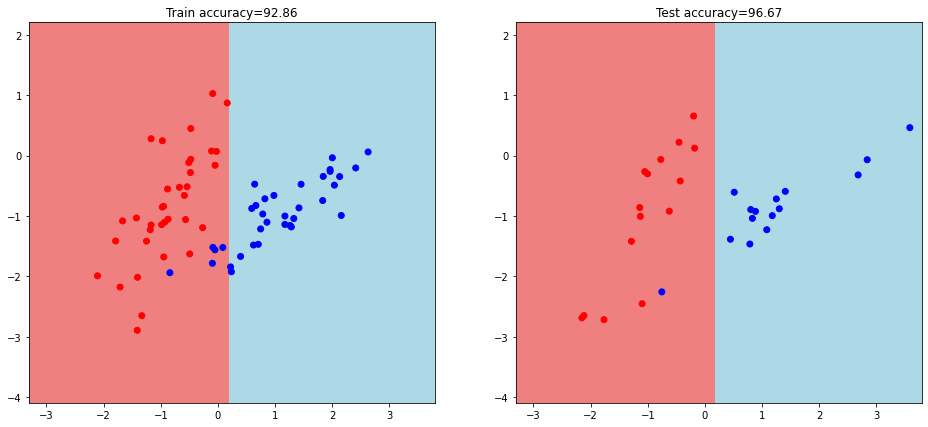

In [146]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')